Count images in test folder of dataset

In [34]:
for defect in ['good','cut','hole','color','thread','metal_contamination']:
    folder = BASE_PATH / 'test' / defect
    if not folder.exists():
        continue
    count = len(list(folder.glob('*.png')))
    print(f"{defect}: {count} images")


good: 28 images
cut: 17 images
hole: 17 images
color: 19 images
thread: 19 images
metal_contamination: 17 images


Visual Anomaly Detection on Full Carpet Dataset (All Test Images)

# === 1) Install & Setup ===

In [35]:
!pip install --quiet openpyxl
import torch, numpy as np, cv2, pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
torch.cuda.empty_cache()


# === 2️) Mount Drive ===

In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# === 3️) Dataset Path ===

In [37]:
BASE_PATH = Path('/content/drive/MyDrive/carpet/carpet')

# === 4️) Build Feature Extractor ===

In [38]:
class ResNetFeat(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT).eval()
        for p in self.model.parameters():
            p.requires_grad = False

        def hook(m, i, o): self.features.append(o)
        self.model.layer1[-1].register_forward_hook(hook)
        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, x):
        self.features = []
        with torch.no_grad():
            _ = self.model(x)
        avg = torch.nn.AvgPool2d(3,1)
        size = self.features[0].shape[-2]
        resize = torch.nn.AdaptiveAvgPool2d(size)
        out = torch.cat([resize(avg(f)) for f in self.features], 1)
        out = out.reshape(out.shape[1], -1).T
        return out / out.norm(dim=1, keepdim=True)


 === 5️) Create Memory Bank (10% Sample from Train Good) ===

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetFeat().to(device)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

mem_feats = []
good_folder = BASE_PATH / 'train/good'
paths = list(good_folder.glob('*.*'))
np.random.shuffle(paths)
paths = paths[:len(paths)//10]

for p in tqdm(paths):
    img = Image.open(p).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)
    mem_feats.append(model(x).cpu())

mem_bank = torch.cat(mem_feats, dim=0).to(device)
print("✅ Memory bank shape:", mem_bank.shape)


100%|██████████| 28/28 [00:02<00:00,  9.42it/s]


✅ Memory bank shape: torch.Size([87808, 1792])


=== 6️) Score Full Test Dataset ===

In [40]:
y_true, y_score, img_names, class_names = [], [], [], []
test_types = ['good','cut','hole','color','thread','metal_contamination']

for defect in test_types:
    folder = BASE_PATH / 'test' / defect
    if not folder.exists(): continue
    images = list(folder.glob('*.*'))
    print(f"Processing {defect}: {len(images)} images")
    for f in tqdm(images):
        img_names.append(f.name)
        class_names.append(defect)
        y_true.append(0 if defect == 'good' else 1)

        img = Image.open(f).convert('RGB')
        x = transform(img).unsqueeze(0).to(device)
        feat = model(x)
        dist = torch.cdist(feat, mem_bank)
        score = torch.max(torch.min(dist, dim=1).values).item()
        y_score.append(score)

Processing good: 28 images


100%|██████████| 28/28 [00:11<00:00,  2.52it/s]


Processing cut: 17 images


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Processing hole: 17 images


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Processing color: 19 images


100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Processing thread: 19 images


100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


Processing metal_contamination: 17 images


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


 === 7️) Find Best Threshold (F1 Optimized) ===

In [41]:
scores = np.array(y_score)
f1s, thresholds = [], np.linspace(scores.min(), scores.max(), 200)
for t in thresholds:
    ypred_tmp = (scores >= t).astype(int)
    f1s.append(f1_score(y_true, ypred_tmp))
best_t = thresholds[int(np.argmax(f1s))]
print("🔧 Best threshold:", best_t)

🔧 Best threshold: 0.26976121467861097


=== 8️) Evaluation ===

🎯 Accuracy: 0.9572649572649573
📈 AUC-ROC: 0.9795345104333868

               precision    recall  f1-score   support

          OK       0.85      1.00      0.92        28
         NOK       1.00      0.94      0.97        89

    accuracy                           0.96       117
   macro avg       0.92      0.97      0.94       117
weighted avg       0.96      0.96      0.96       117



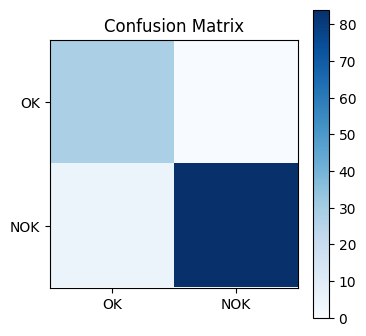

In [42]:
y_pred = (scores >= best_t).astype(int)
print("🎯 Accuracy:", accuracy_score(y_true, y_pred))
print("📈 AUC-ROC:", roc_auc_score(y_true, scores))
print("\n", classification_report(y_true, y_pred, target_names=['OK','NOK']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks([0,1], ['OK','NOK'])
plt.yticks([0,1], ['OK','NOK'])
plt.colorbar()
plt.show()

=== 9️) Export to Excel ===

In [44]:
df = pd.DataFrame({
    'Image': img_names,
    'Class': class_names,
    'Ground Truth': y_true,
    'Prediction': y_pred,
    'Anomaly Score': y_score
})
out_file = '/content/carpet_anomaly_full_results.xlsx'
df.to_excel(out_file, index=False)
print("📄 Results saved to:", out_file)


📄 Results saved to: /content/carpet_anomaly_full_results.xlsx


# === 🔍 Example Heatmap + IoU/Dice for 1 Defective Image ===
# Load one test image and ground truth mask, compute segmentation, show heatmap, IoU, Dice


IoU: 0.5135, Dice Score: 0.6786


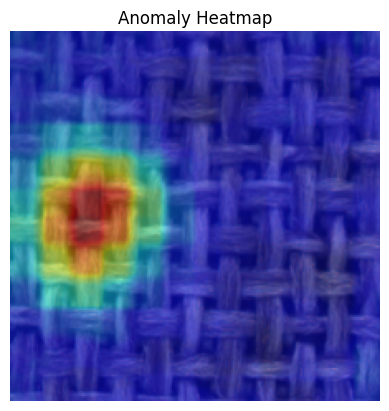

In [45]:
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import jaccard_score, f1_score
import matplotlib.pyplot as plt

# Example: 1 defective image
defective_img = BASE_PATH / 'test/cut/000.png'
gt_mask_path = BASE_PATH / 'ground_truth/cut/000_mask.png'

img = Image.open(defective_img).convert('RGB')
x = transform(img).unsqueeze(0).to(device)

feat = model(x)
distances = torch.cdist(feat, mem_bank)
patch_scores, _ = torch.min(distances, dim=1)

num_patches = int(np.sqrt(patch_scores.shape[0]))
segm_map = patch_scores.view(1, 1, num_patches, num_patches)
segm_map = torch.nn.functional.interpolate(segm_map, size=(224, 224), mode='bilinear')
pred_mask = (segm_map.squeeze().cpu().numpy() > best_t * 1.25).astype(np.uint8)

# ✅ Resize GT mask to match prediction
gt_mask = imread(str(gt_mask_path), as_gray=True)
gt_mask = resize(gt_mask, (224, 224), order=0, preserve_range=True, anti_aliasing=False)
gt_mask = (gt_mask > 0.5).astype(np.uint8)

# IoU and Dice
iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
dice = f1_score(gt_mask.flatten(), pred_mask.flatten())
print(f"IoU: {iou:.4f}, Dice Score: {dice:.4f}")

# Show heatmap
plt.imshow(img)
plt.imshow(segm_map.squeeze().cpu().numpy(), cmap='jet', alpha=0.5)
plt.title("Anomaly Heatmap")
plt.axis('off')
plt.show()


# === 🧾 Loop Through All Defects: Heatmaps + PDF Report ===
# Generate and save visual anomaly heatmaps for each image in the test set and export to PDF


In [46]:
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import jaccard_score, f1_score
from matplotlib.backends.backend_pdf import PdfPages

output_pdf_path = "/content/carpet_heatmap_report.pdf"
os.makedirs("/content/carpet_temp/", exist_ok=True)

iou_scores, dice_scores, iou_classes = [], [], []

with PdfPages(output_pdf_path) as pdf:
    for defect_type in ['cut', 'hole', 'color', 'thread', 'metal_contamination']:
        test_path = BASE_PATH / f'test/{defect_type}'
        gt_path = BASE_PATH / f'ground_truth/{defect_type}'

        for img_file in test_path.glob('*.*'):
            mask_file = gt_path / img_file.name.replace('.png', '_mask.png')
            if not mask_file.exists():
                continue

            # Load and transform image
            img = Image.open(img_file).convert('RGB')
            x = transform(img).unsqueeze(0).to(device)

            # Feature extraction and scoring
            feat = model(x)
            distances = torch.cdist(feat, mem_bank)
            patch_scores, _ = torch.min(distances, dim=1)

            num_patches = int(np.sqrt(patch_scores.shape[0]))
            segm_map = patch_scores.view(1, 1, num_patches, num_patches)
            segm_map = torch.nn.functional.interpolate(segm_map, size=(224, 224), mode='bilinear')
            pred_mask = (segm_map.squeeze().cpu().numpy() > best_t * 1.25).astype(np.uint8)

            # Load and resize ground truth
            gt_mask = imread(str(mask_file), as_gray=True)
            gt_mask = resize(gt_mask, (224, 224), order=0, preserve_range=True, anti_aliasing=False)
            gt_mask = (gt_mask > 0.5).astype(np.uint8)

            if pred_mask.shape != gt_mask.shape:
                print(f"⚠️ Skipping {img_file.name} due to shape mismatch.")
                continue

            # Compute metrics
            iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
            dice = f1_score(gt_mask.flatten(), pred_mask.flatten())
            iou_scores.append(iou)
            dice_scores.append(dice)
            iou_classes.append(defect_type)

            # Plot to PDF
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis('off')

            ax[1].imshow(gt_mask, cmap='gray')
            ax[1].set_title("Ground Truth Mask")
            ax[1].axis('off')

            ax[2].imshow(img)
            ax[2].imshow(segm_map.squeeze().cpu().numpy(), cmap='jet', alpha=0.5)
            ax[2].set_title(f"Anomaly Heatmap\nIoU: {iou:.2f}, Dice: {dice:.2f}")
            ax[2].axis('off')

            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

print(f"📄 Final PDF report saved to: {output_pdf_path}")
print(f"📊 Mean IoU: {np.mean(iou_scores):.4f}")
print(f"📊 Mean Dice: {np.mean(dice_scores):.4f}")


📄 Final PDF report saved to: /content/carpet_heatmap_report.pdf
📊 Mean IoU: 0.2777
📊 Mean Dice: 0.3959
